# Pipeline Notebook 

## Imports

In [1]:
import handwriting
import keras
import tensorflow as tf
import handwriting.preprocess as preprocess

## Bounding Box

### Bounding Box Modell

## Show Image Real Image

In [17]:
from bounding_box.model import load_weight_model,predict_image,get_image_as_array, show_image 
from bounding_box.config import NUM_CLASSES_ALL,BBOX_PATH,MAIN_BBOX_DETECTOR_MODEL,SUB_BBOX_DETECTOR_MODEL  
from bounding_box.model import load_weight_model, predict_image,plot_image, get_templated_data, edit_sub_boxes_cut_links, edit_sub_boxes_cut_top
from bounding_box.template import build_templating_data

bbox_model = load_weight_model(r"bounding_box\workspace\models\main_bbox_detector_model.h5",4)
image_path = "data_zettel/filled_resized/image_0006.jpg"
main_boxes, confidence, classes = predict_image(image_path, bbox_model)

1/1 [==============================] - 4s 4s/step


In [18]:
#show_image((image_path), main_boxes,confidence,classes )  

## Templating

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

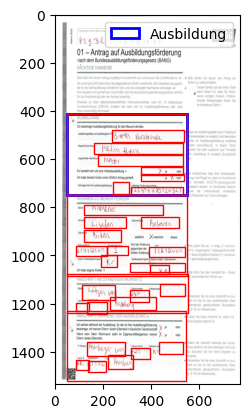

In [19]:
org_ms_boxes_person, org_ms_boxes_wohnsitz, org_ms_boxes_ausbildung, org_ms_boxes_wwa, person_class_ids, ausbildung_class_ids, wohnsitz_class_ids, wwa_class_ids, widthOrgImag, heightOrgImag = build_templating_data()

ausbildung, person, wohnsitz, wwa, best_predicted = get_templated_data(main_boxes, confidence, classes, org_ms_boxes_person,
                                                                       org_ms_boxes_wohnsitz, org_ms_boxes_ausbildung,
                                                                       org_ms_boxes_wwa, person_class_ids,
                                                                       ausbildung_class_ids, wohnsitz_class_ids,
                                                                       wwa_class_ids)


top_cut = False
if top_cut:
    ausbildung_cut_top, person_cut_top, wohnsitz_cut_top, wwa_cut_top = edit_sub_boxes_cut_top(ausbildung, person, wohnsitz, wwa)
    sub_boxes = ausbildung_cut_top[0] + person_cut_top[0] +  wohnsitz_cut_top[0] +  wwa_cut_top[0] 
    plot_image((image_path), ausbildung_cut_top, person_cut_top, wohnsitz_cut_top, wwa_cut_top, best_predicted)
else:
    ausbildung_cut_links, person_cut_links, wohnsitz_cut_links, wwa_cut_links = edit_sub_boxes_cut_links(ausbildung, person, wohnsitz, wwa)
    sub_boxes = ausbildung_cut_links[0]  + person_cut_links[0]  + wohnsitz_cut_links[0]  + wwa_cut_links[0] 
    plot_image(image_path, ausbildung_cut_links, person_cut_links, wohnsitz_cut_links, wwa_cut_links, best_predicted)


In [20]:
print(len(sub_boxes))

33


### ROI Crop

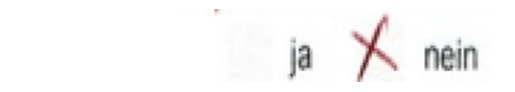

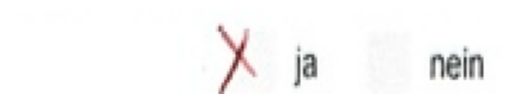

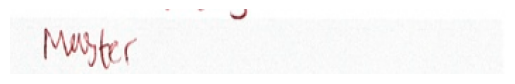

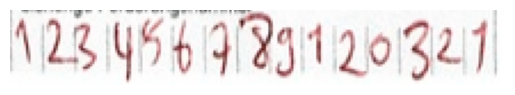

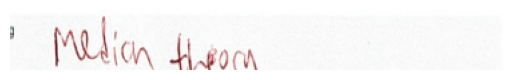

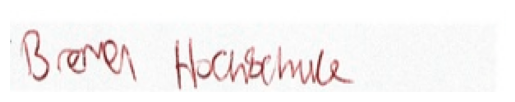

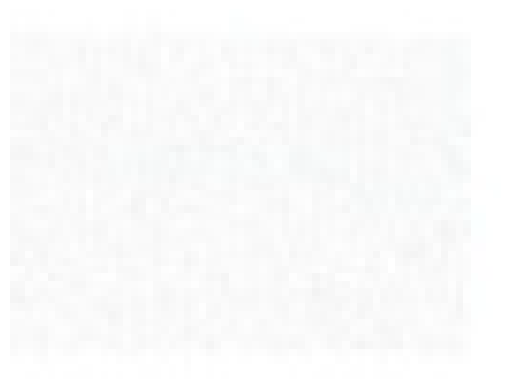

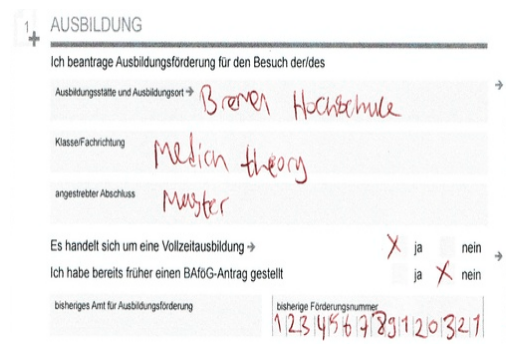

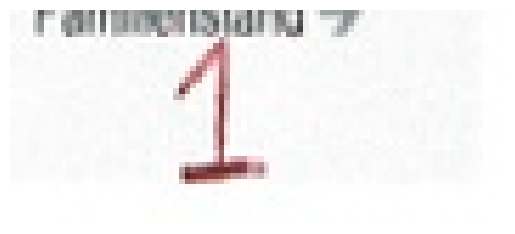

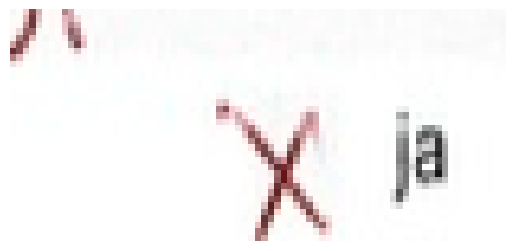

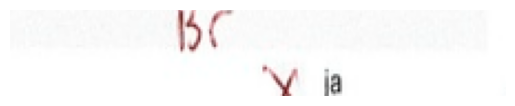

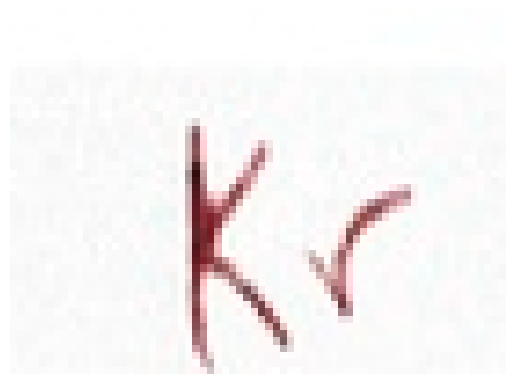

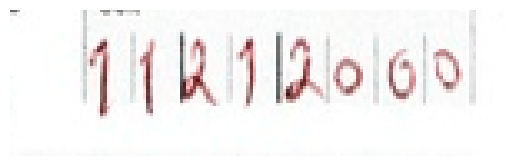

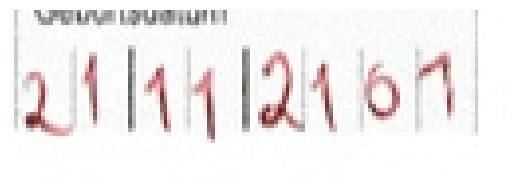

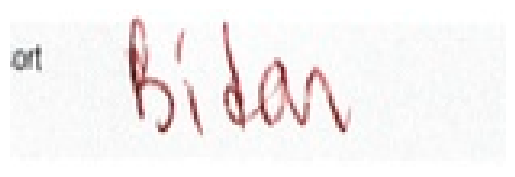

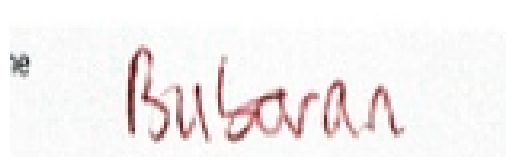

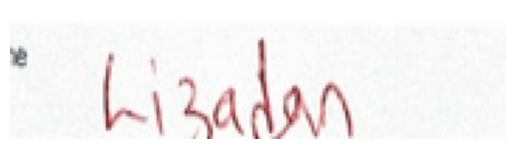

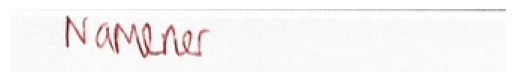

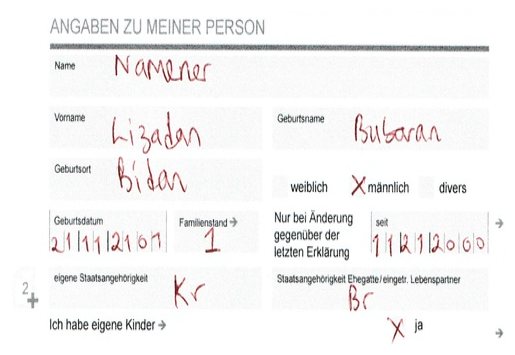

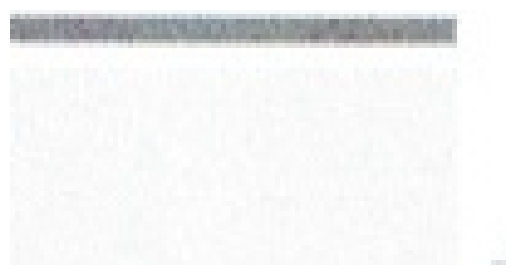

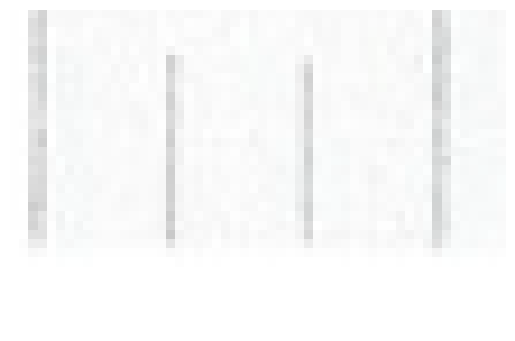

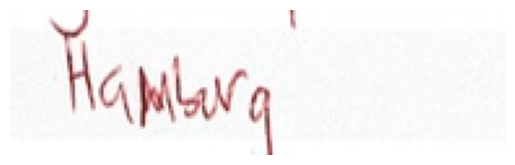

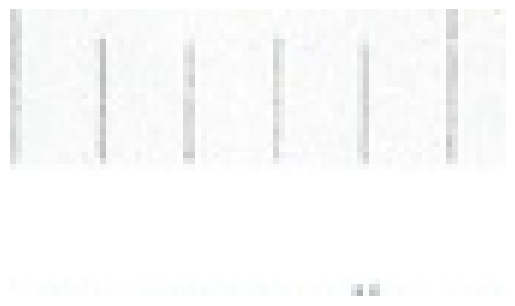

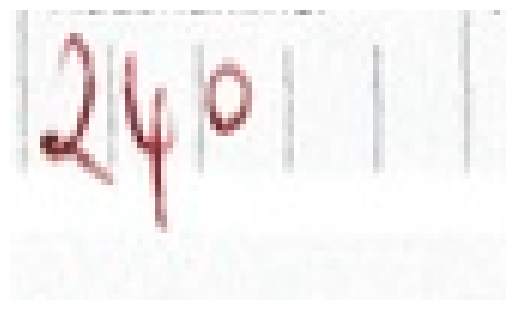

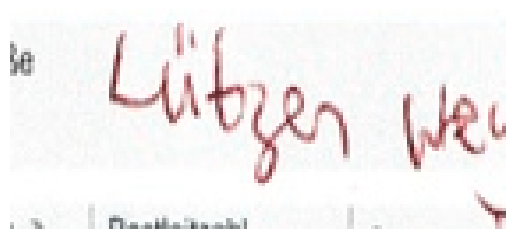

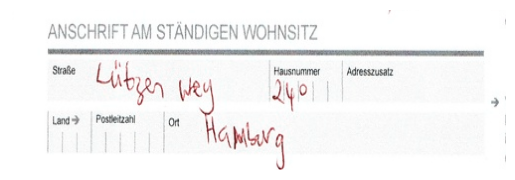

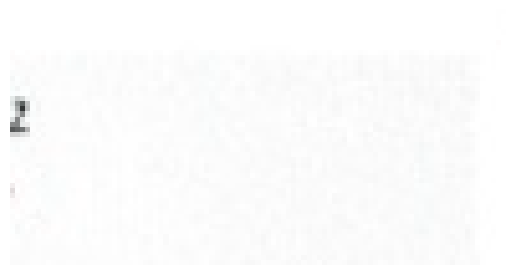

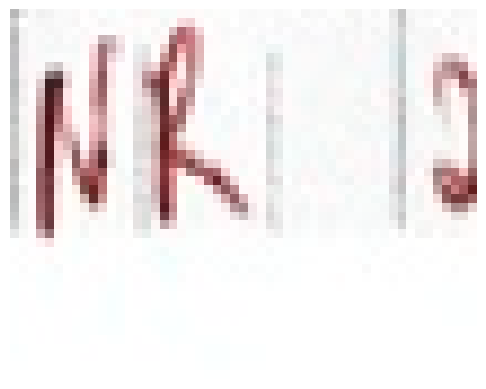

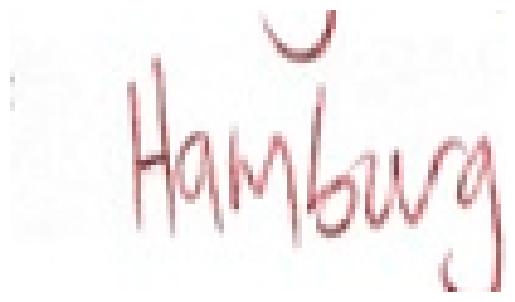

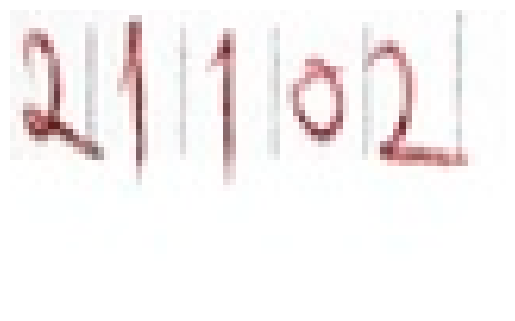

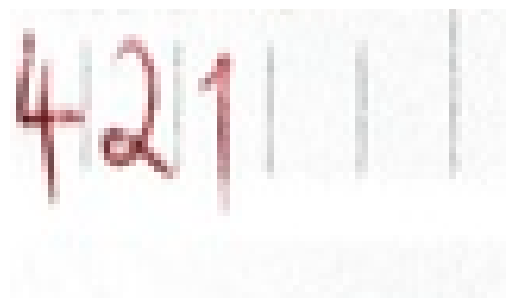

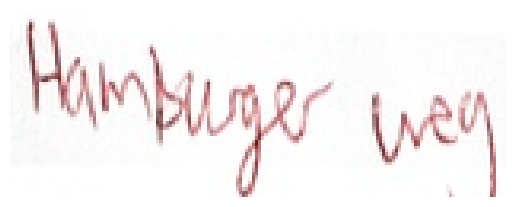

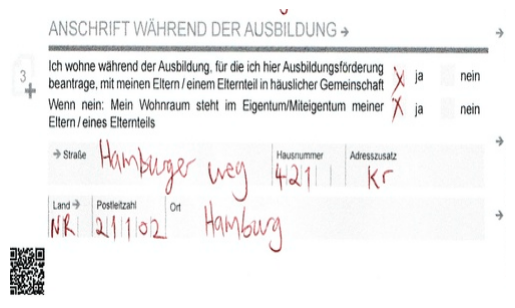

In [21]:
# Crop ROI
import cv2
from bounding_box.ressize import resize_imaged_without_expand_dim
from bounding_box.config import YOLO_WIDTH, YOLO_HEIGHT
def crop(xmin, ymin, xmax, ymax, image_path):
    image = cv2.imread(image_path)
    image = resize_imaged_without_expand_dim(image, YOLO_WIDTH, YOLO_HEIGHT)
    xmin = int(round(xmin))
    ymin = int(round(ymin))
    xmax = int(round(xmax))
    ymax = int(round(ymax))
    # width = int(round(width))
    # height = int(round(height))
    # rowBeg = y
    # rowEnd = y + height
    # columnBeg = x
    # columnEnd = x + width
    imgCropped = image[ymin:ymax, xmin:xmax]
    return imgCropped

import matplotlib.pyplot as plt
images_cropped = []
for b in sub_boxes:
    xmin, ymin, xmax, ymax = b
    imgCropped = crop(xmin, ymin, xmax, ymax, image_path)
    images_cropped.append(imgCropped)
    plt.axis("off")
    plt.imshow(imgCropped)
    plt.show()


## Handwriting Recognition

### Preprocess Image

In [23]:
import numpy as np
import utils.configs as cfg
config_path = "utils/configs.json"
config = cfg.Config(config_path)
IMAGE_WIDTH = config.get_model_parameter()["width"] # default: 1024
IMAGE_HEIGHT = config.get_model_parameter()["height"] # default: 128

img_size=(IMAGE_WIDTH, IMAGE_HEIGHT)
images = []
for image in images_cropped:
    image = np.mean(image, axis=2, keepdims=True)
    image = preprocess.distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    images.append(image)

### Plot Images

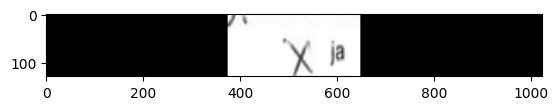

In [24]:
plot_image = images[9]
plot_image = np.transpose(plot_image, (1, 0, 2))
plot_image = np.flipud(plot_image)
plt.imshow(plot_image[:, :, 0],cmap='gray')

# Show the plot
plt.show()

### Handwriting Recognition Neural Network

In [26]:
from keras.models import load_model
import os
import handwriting.tokenizer as tokenizer
import pickle
# Load from pickle file
with open('bafog_handwriting_model_characters.pkl', 'rb') as file:
    loaded_max_len, loaded_characters = pickle.load(file)

# Print loaded data
print("Loaded max_len:", loaded_max_len)
print("Loaded characters:", loaded_characters)

Loaded max_len: 65
Loaded characters: ['[UNK]', '-', '.', '0', '1', '2', '4', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', 'ß', 'ä', 'ö', 'ü']


In [27]:
from keras.layers import StringLookup
char_to_num = StringLookup(vocabulary=list(loaded_characters), mask_token=None)
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :loaded_max_len]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


def load_model_and_weights():
    model_weight_path = "handwriting/models/dense_and_full/transferlearningTestingModel_weights.keras"
    model_path = "handwriting/models/dense_and_full"
    print(model_path)
    if os.path.exists(model_path):
        print("Loading pre-trained model and weights...")
        model = load_model(model_path)
        model.load_weights(model_weight_path)
        print("Model and weights loaded successfully.")

        return model
    else:
        print("No pre-trained model or weights found.")
        return None

In [28]:
# Neural Network Handwriting
handwriting_model = load_model_and_weights()
prediction_model = keras.models.Model(handwriting_model.get_layer(name="image").input, handwriting_model.get_layer(name="dense2").output)

handwriting/models/dense_and_full
Loading pre-trained model and weights...
Model and weights loaded successfully.


In [29]:
predicted_texts = []
# Prediction
for image in images:
    preds = prediction_model.predict(tf.expand_dims(image, axis=0))
    pred_texts = decode_batch_predictions(preds)
    selected_pred_text = pred_texts[0]
    selected_pred_text = selected_pred_text.replace("|"," ")
    predicted_texts.append(selected_pred_text)

1/1 [==============================] - 0s 56ms/step


### Predicted Texts

In [30]:
print(predicted_texts)

['oArain', 'EWenn', 'Mst', 'istteebsel', 'Belien ttoan', 'Bom Hchahule', '', 'si', '', 'D', 's', 'K', 'Pklobio', 'Lllilaroni', 'Bidan', 'Bularan', 'Liaaten', 'Namener', 'isg', '', '', 'Hamburg', '', 'Ke', 'Lützen We', 'vittr', '', 'AR', 'Hanlug', 'AoE', 'Aal', 'Hmbuger Weg', 's']


### Spell Checker

In [31]:
from spellchecker import SpellChecker

# spell = SpellChecker()

# Initialisierung des Spellcheckers für Deutsch
spell = SpellChecker(language='de')

# Hinzufügen von benutzerdefinierten Wörtern
# custom_words = ['Colin', 'asddf']
# spell.word_frequency.load_words(custom_words)

# Verwendung einer Datei von häufigen Wörtern oder Fachbegriffen
# with open('/data/custom_dictionary.txt') as f:
#     custom_words = f.read().splitlines()
# spell.word_frequency.load_words(custom_words)

output_text = []
for text in predicted_texts:
    words = [word for word in text.split(" ") if word != '']
    #Spellchecker
    corrected_text = ' '.join([spell.correction(word) if spell.correction(word) is not None else word for word in text.split()])
    output_text.append(corrected_text)
print(output_text)

['daran', 'wenn', 'ist', 'istteebsel', 'bedien total', 'vom Hchahule', '', 'si', '', 'D', 's', 'K', 'Pklobio', 'Lllilaroni', 'bin', 'Bularan', 'lauten', 'namens', 'ist', '', '', 'Hamburg', '', 'je', 'nützen We', 'bitte', '', 'er', 'hang', 'are', 'mal', 'Hmbuger Weg', 's']


# Plot Predicted Text and Image

In [32]:
def plot_evaluation(images, texts): 
    for i in range(16):
        pred_texts = texts[i]
        title = f"Prediction: {pred_texts}"
        plot_image = images[i]
        plot_image = np.transpose(plot_image, (1, 0, 2))
        plot_image = np.flipud(plot_image)
        plt.title(title)
        plt.imshow(plot_image[:, :, 0],cmap='gray')
        plt.show()
    


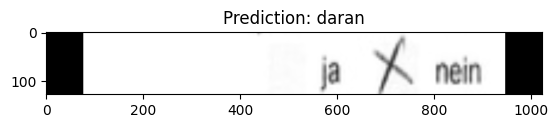

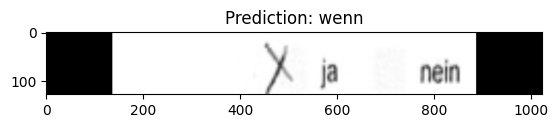

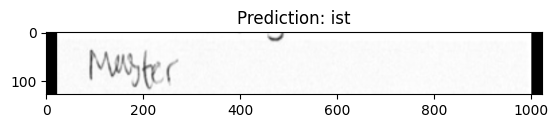

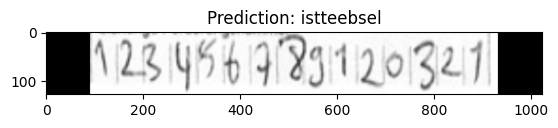

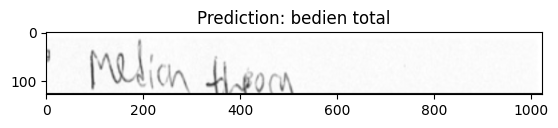

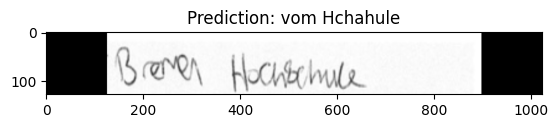

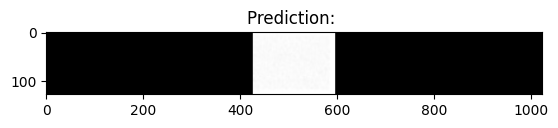

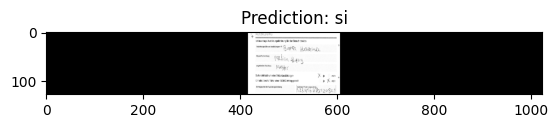

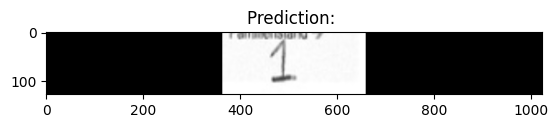

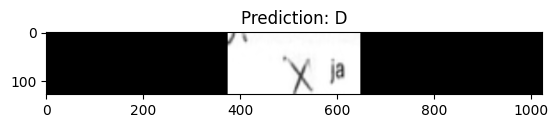

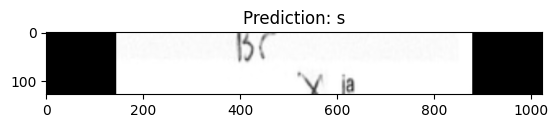

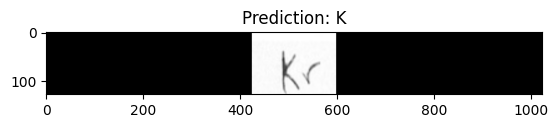

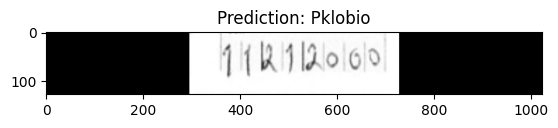

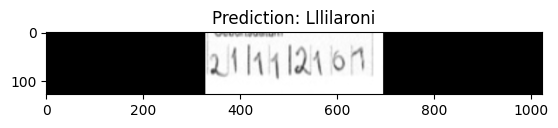

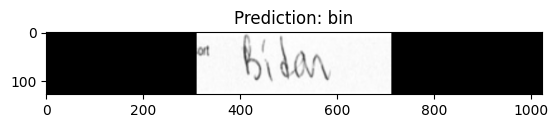

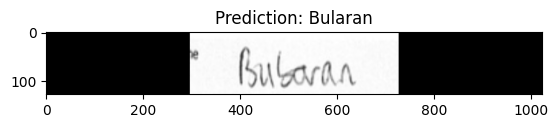

In [33]:
plot_evaluation(images, output_text)